# Currency Market Predictor - Recurrent Neural Netowork

Predicting EURUSD market

In [561]:
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.tools.set_credentials_file(username='jafferwilson', api_key='EkP7ePXHyQaUZxPIX2Zv')
from sklearn import preprocessing
from matplotlib.patches import Rectangle

## Reading Training,Testing, and Forecast Datasets

In [562]:
dataset_train = pd.read_csv('EURUSD_M1TechnicalIndicators.csv',usecols=[1,2,3,4,5,6,7,8,9,10,11,12,13])
# dataset_train.head(10)

In [563]:
dataset_test = pd.read_csv('Test_EURUSD_M1TechnicalIndicators.csv',usecols=[1,2,3,4,5,6,7,8,9,10,11,12,13],nrows=50)
dataset_test.head(10)

,open,high,low,close,closeTarget,k,d,atr,macdmain,macdsgnal,bbup,bbmid,bblow
0,1.22161,1.22224,1.22154,1.22224,1.22165,39.444444,14.259259,0.000215,-0.000099,14.259259,1.223272,1.222352,1.221432
1,1.22179,1.22179,1.22165,1.22165,1.22159,3.333333,1.111111,0.000200,-0.000199,1.111111,1.223383,1.222399,1.221414
2,1.22183,1.22189,1.22159,1.22159,1.22184,0.000000,0.775194,0.000215,-0.000195,0.775194,1.223454,1.222475,1.221497
3,1.22198,1.22204,1.22162,1.22184,1.22200,0.000000,9.429040,0.000198,-0.000151,9.429040,1.223510,1.222560,1.221610
4,1.22203,1.22203,1.22199,1.22200,1.22205,2.325581,32.139663,0.000237,-0.000121,32.139663,1.223565,1.222630,1.221696
5,1.22227,1.22227,1.22189,1.22205,1.22228,25.961538,62.943416,0.000247,-0.000099,62.943416,1.223588,1.222683,1.221778
6,1.22250,1.22251,1.22212,1.22228,1.22249,68.131868,78.734015,0.000227,-0.000060,78.734015,1.223570,1.222713,1.221855
7,1.22252,1.22252,1.22249,1.22249,1.22253,94.736842,70.451253,0.000214,-0.000047,70.451253,1.223566,1.222730,1.221895
8,1.22232,1.22253,1.22232,1.22253,1.22231,73.333333,45.456667,0.000226,-0.000075,45.456667,1.223569,1.222741,1.221912
9,1.22225,1.22233,1.22218,1.22231,1.22225,43.283582,23.110125,0.000219,-0.000130,23.110125,1.223570,1.222746,1.221923


In [564]:
dataset_forecast = pd.read_csv('forecast.csv',usecols=[1,2,3,4,5,6,7,8,9,10,11,12],encoding='utf-16',sep='\t',nrows=50)
dataset_forecast.head(10)

,open,high,low,close,k,d,atr,macdmain,macdsgnal,bbup,bbmid,bblow
0,1.17111,1.17112,1.17107,1.17108,8.333333,7.407407,0.000056,-0.000008,7.407407,1.171204,1.171088,1.170972
1,1.17094,1.17097,1.17094,1.17097,0.000000,5.555556,0.000056,-0.000027,5.555556,1.171207,1.171081,1.170955
2,1.17097,1.17098,1.17097,1.17098,2.941176,3.758170,0.000055,-0.000034,3.758170,1.171210,1.171080,1.170949
3,1.17098,1.17137,1.17098,1.17134,56.716418,19.885865,0.000082,0.000018,19.885865,1.171260,1.171099,1.170937
4,1.17133,1.17151,1.17105,1.17140,85.263158,48.306917,0.000103,0.000055,48.306917,1.171321,1.171118,1.170916
5,1.17142,1.17142,1.17105,1.17106,72.357724,71.445766,0.000124,0.000020,71.445766,1.171320,1.171119,1.170918
6,1.17106,1.17150,1.17106,1.17143,74.045802,77.222228,0.000151,0.000056,77.222228,1.171378,1.171137,1.170897
7,1.17143,1.17144,1.17112,1.17116,51.200000,65.867842,0.000174,0.000031,65.867842,1.171381,1.171142,1.170904
8,1.17120,1.17136,1.17107,1.17124,61.344538,62.196780,0.000189,0.000028,62.196780,1.171390,1.171151,1.170912
9,1.17124,1.17131,1.17124,1.17128,45.045045,52.529861,0.000191,0.000031,52.529861,1.171404,1.171161,1.170919


# Formulating or scaling the Trainging datasets

In [565]:
train  = dataset_train.filter(['open','high','low','close','closeTarget',"k","d","atr","macdmain","macdsgnal","bbup","bbmid","bblow"], axis=1)
x = train.values #returns a numpy array

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
datasetTrain = pd.DataFrame(x_scaled)
datasetTrain.columns = ['open','high','low','close','closeTarget',"k","d","atr","macdmain","macdsgnal","bbup","bbmid","bblow"]
# datasetTrain.head(10) 

# Formulating or scaling the Testing datasets

In [566]:
test = dataset_test.filter(['open','high','low','close','closeTarget',"k","d","atr","macdmain","macdsgnal","bbup","bbmid","bblow"], axis=1)
x = test.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
datasetTest = pd.DataFrame(x_scaled)
datasetTest.columns = ['open','high','low','close','closeTarget',"k","d","atr","macdmain","macdsgnal","bbup","bbmid","bblow"]
# datasetTest['openshifted'] = datasetTest.open.shift(-1)
datasetTest.head(10)

,open,high,low,close,closeTarget,k,d,atr,macdmain,macdsgnal,bbup,bbmid,bblow
0,0.022472,0.321429,0.028571,0.370787,0.039326,0.394444,0.135894,0.638298,0.220484,0.135894,0.645998,0.456451,0.174702
1,0.123596,0.053571,0.091429,0.039326,0.005618,0.033333,0.003385,0.548936,0.000000,0.003385,0.724737,0.517354,0.147918
2,0.146067,0.113095,0.057143,0.005618,0.146067,0.000000,0.000000,0.638298,0.007640,0.000000,0.775600,0.618206,0.270844
3,0.230337,0.202381,0.074286,0.146067,0.235955,0.000000,0.087215,0.536170,0.106609,0.087215,0.814985,0.728880,0.440311
4,0.258427,0.196429,0.285714,0.235955,0.264045,0.023256,0.316095,0.770213,0.171310,0.316095,0.854347,0.821218,0.568022
5,0.393258,0.339286,0.228571,0.264045,0.393258,0.259615,0.626539,0.829787,0.221364,0.626539,0.870255,0.889980,0.691323
6,0.522472,0.482143,0.360000,0.393258,0.511236,0.681319,0.785679,0.710638,0.306674,0.785679,0.857656,0.928618,0.805912
7,0.533708,0.488095,0.571429,0.511236,0.533708,0.947368,0.702204,0.634043,0.336408,0.702204,0.854639,0.952194,0.866006
8,0.421348,0.494048,0.474286,0.533708,0.410112,0.733333,0.450305,0.706383,0.273252,0.450305,0.856769,0.965291,0.891385
9,0.382022,0.375000,0.394286,0.410112,0.376404,0.432836,0.225094,0.659574,0.151398,0.225094,0.857861,0.973150,0.907003


# Formulating or scaling the Forecasting datasets

In [567]:
dataset_forecast['closeTarget'] = 0
forecast = dataset_forecast.filter(['open','high','low','close','closeTarget',"k","d","atr","macdmain","macdsgnal","bbup","bbmid","bblow"], axis=1)
x = forecast.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
datasetforecast = pd.DataFrame(x_scaled)
dataset_forecast.closeTarget = 0
datasetforecast.columns = ['open','high','low','close',"k","d","atr","macdmain","macdsgnal","bbup","bbmid","bblow",'closeTarget']
datasetforecast.fillna(0)
datasetforecast.closeTarget[:] = 0
# datasetforecast.head(10)

# Functions Needed in this process

In [568]:
# Draws rectangle separated
def draw_rects(ax, quotes,colordraw, width=5., height=1., yloc=0., alpha=1.0):

    OFFSET = 0#width/2.0
    patches = []
    count =0
    for q in range(quotes):
        rect = Rectangle(
            xy=(count+OFFSET, yloc),
            width=width,
            height=height,
            facecolor=colordraw[count],
            edgecolor=colordraw[count],
        )
        count += 1
        OFFSET += 9
        rect.set_alpha(alpha)
        patches.append(rect)
        ax.add_patch(rect)

    ax.autoscale_view()

    return patches

In [569]:
#returns the color of the candle which is predicted or forecasted by the model checkpoint
def GetPredictedColor(test_pred_list):
    colorpredicted = []
    for index in range(len(test_pred_list)-1):
        if test_pred_list[index+1] > test_pred_list[index]: colorpredicted.append('g')
        if test_pred_list[index+1] < test_pred_list[index]: colorpredicted.append('r')
        if test_pred_list[index+1] == test_pred_list[index]: colorpredicted.append('k')
    if(colorpredicted[0] =='r'): colorpredicted.insert(0,'g')
    if(colorpredicted[0] =='g'): colorpredicted.insert(0,'r')
    if(colorpredicted[0] =='k'): colorpredicted.insert(0,'k')
    print(len(colorpredicted))
    return colorpredicted

In [570]:
def PlotmePercent(match,unmatch):
    labels = 'Unmatched Output Forcast','Matched Output Forcast'
    sizes = [match,unmatch]
    colors = ['silver', 'gold']
    explode = (0.1, 0,)  # explode 1st slice

    # Plot
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=140)

    plt.axis('equal')
    plt.show()

In [571]:
def PlotmeGraphwithBars(Bardataset,original_dataset,model_output,model_label):
    fig, ax = plt.subplots(1,1)

    # Instead of set_figwidth(30)
    fig.set_size_inches(30, 10, forward=True)
    # quotes = np.genfromtxt("./out.csv", skip_header=1, delimiter=',')
    p1 = draw_rects(ax, Bardataset.color_original.count(),colordraw=Bardataset.color_original, yloc=4)
    # print(xTrain[:10])
    p2 = draw_rects(ax, Bardataset.color_forecasted.count(),colordraw=Bardataset.color_forecasted, yloc=1)
    labels = [item.get_text() for item in ax.get_yticklabels()]
    labels[2] = model_label
    labels[8] = 'Real'
    ax.set_yticklabels(labels)
    plt.figure(figsize=(21,7))
    plt.plot(original_dataset.close.shift(-1),label='Price',color='blue',marker='^')
    plt.plot(model_output,label=model_label,color='red',marker='v')
    plt.title('Price vs '+model_label)
    plt.legend(loc='upper left')
    plt.show()

## Hyperparams

In [572]:
tf.reset_default_graph()
num_epochs = 5000

batch_size = 1

total_series_length = len(dataset_train.index)

truncated_backprop_length = 3 #The size of the sequence

state_size = 12 #The number of neurons

num_features = 12#9#4
num_classes = 1 #[1,0]

num_batches = total_series_length//batch_size//truncated_backprop_length

min_test_size = 100

print('The total series length is: %d' %total_series_length)
print('The current configuration gives us %d batches of %d observations each one looking %d steps in the past' 
      %(num_batches,batch_size,truncated_backprop_length))

The total series length is: 30203
The current configuration gives us 10067 batches of 1 observations each one looking 3 steps in the past


## Train-Test split

In [573]:
# datasetTrain = datasetNorm[dataset.index < num_batches*batch_size*truncated_backprop_length]


# for i in range(min_test_size,len(datasetNorm.index)):
    
#     if(i % truncated_backprop_length*batch_size == 0):
#         test_first_idx = len(datasetNorm.index)-i
#         break

# datasetTest =  datasetNorm[dataset.index >= test_first_idx]

In [574]:
# datasetTrain.head(2)

In [575]:
# datasetTest.head(5)

In [576]:
# datasetTrain

In [577]:
xTrain = datasetTrain[['open','high','low','close',"k","d","atr","macdmain","macdsgnal","bbup","bbmid","bblow"]].as_matrix()
yTrain = datasetTrain['closeTarget'].as_matrix()

In [578]:
# xTrain


In [579]:
# xTrain[:,3]

In [580]:
# yTrain[0]

In [581]:
# np.count_nonzero(xTrain, axis=0)

In [582]:
print(xTrain[0:3],'\n',yTrain[0:3])

[[0.51502529 0.50192251 0.5305564  0.51458333 0.66101695 0.84903097
  0.10278171 0.5041859  0.84903097 0.50698884 0.5237456  0.53235088]
 [0.51324011 0.50192251 0.53177258 0.51517857 0.88607595 0.90104971
  0.09382367 0.50636443 0.90104971 0.50836477 0.52444051 0.53230553]
 [0.51770306 0.50428867 0.53602919 0.51785714 1.         0.75569106
  0.10278171 0.50815437 0.75569106 0.50963026 0.52511964 0.53234223]] 
 [0.51517857 0.51785714 0.51785714]


In [583]:
xTest = datasetTest[['open','high','low','close',"k","d","atr","macdmain","macdsgnal","bbup","bbmid","bblow"]].as_matrix()
yTest = datasetTest['closeTarget'].as_matrix()

In [584]:
# xTest[0]

In [585]:
# yTest[0]

In [586]:
# np.count_nonzero(xTest, axis=0)

In [587]:
# print(xTest[0:3],'\n',yTest[0:3])

## Visualize starting price data

In [588]:
# plt.figure(figsize=(25,5))
# plt.plot(xTrain[:,3])
# plt.title('Train (' +str(len(xTrain))+' data points)')
# plt.show()
# plt.figure(figsize=(10,3))
# plt.plot(xTest[:,0])
# plt.title('Test (' +str(len(xTest))+' data points)')
# plt.show()

In [589]:


# fig, ax = plt.subplots(1,1)

# # Instead of set_figwidth(30)
# fig.set_size_inches(30, 10, forward=True)
# # quotes = np.genfromtxt("./out.csv", skip_header=1, delimiter=',')
# p1 = draw_rects(ax, xTest[:50], yloc=1)
# # print(xTrain[:10])
# p2 = draw_rects(ax, xTrain[5:50], yloc=4)
# labels = [item.get_text() for item in ax.get_yticklabels()]
# labels[2] = 'Real'
# labels[8] = 'Predicted'
# ax.set_yticklabels(labels)

# plt.show()

## Placeholders

In [590]:
batchX_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_features],name='data_ph')
batchY_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_classes],name='target_ph')

## Weights and biases
Because is a 3 layer net:
1. Input
2. Hidden Recurrent layer
3. Output

We need 2 pairs of W and b

In [591]:
W2 = tf.Variable(initial_value=np.random.rand(state_size,num_classes),dtype=tf.float32)
tf.summary.histogram("W", W2)
b2 = tf.Variable(initial_value=np.random.rand(1,num_classes),dtype=tf.float32)
tf.summary.histogram("b2", b2)

<tf.Tensor 'b2:0' shape=() dtype=string>

Unpack

In [592]:
labels_series = tf.unstack(batchY_placeholder, axis=1)

## Forward pass - Unroll the cell

Input to recurrent

In [593]:

cell = tf.contrib.rnn.BasicRNNCell(num_units=state_size)
states_series, current_state = tf.nn.dynamic_rnn(cell=cell,inputs=batchX_placeholder,dtype=tf.float32)
tf.summary.histogram("states_series", states_series)
tf.summary.histogram("current_state", current_state)

<tf.Tensor 'current_state:0' shape=() dtype=string>

In [594]:
states_series = tf.transpose(states_series,[1,0,2])

## Backward pass - Output

In [595]:
last_state = tf.gather(params=states_series,indices=states_series.get_shape()[0]-1)
last_label = tf.gather(params=labels_series,indices=len(labels_series)-1)

## Weights and bias out

In [596]:
weight = tf.Variable(tf.truncated_normal([state_size,num_classes]))
tf.summary.histogram("weight", weight)
bias = tf.Variable(tf.constant(0.1,shape=[num_classes]))
tf.summary.histogram("bias", bias)

<tf.Tensor 'bias:0' shape=() dtype=string>

## Prediction, Loss & Optimizer

In [597]:
prediction = tf.matmul(last_state,weight) + bias
prediction

<tf.Tensor 'add:0' shape=(?, 1) dtype=float32>

In [598]:
loss = tf.reduce_mean(tf.squared_difference(last_label,prediction))

train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

c:\python35\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



In [599]:
saver = tf.train.Saver() # Save and restore model variabe
print(tf.train.latest_checkpoint("models")) # checks the latest created model checkpoint  and returns the model path

models\model6120.ckpt


#  Train the model and save it

In [600]:
# loss_list = []
# with tf.Session() as sess:
#      train_writer = tf.summary.FileWriter('logs', sess.graph)
#      tf.global_variables_initializer().run()
#      counter = 0
#      try:
#          with open ("Checkpointcounter.txt","r") as file:
#              value = file.read()
#      except FileNotFoundError:
#          print("First Time Running Training!....")
#      if(tf.train.checkpoint_exists("models\\model"+value+".ckpt")):
#          saver.restore(sess, "models\\model"+value+".ckpt")
#          print("models\\model"+value+".ckpt Session Loaded for Training")
#          counter = int(value)
#      for epoch_idx in range(num_epochs):
               
#          print('Epoch %d' %epoch_idx)
#          counter+= 1;
#          for batch_idx in range(num_batches):
#              start_idx = batch_idx * truncated_backprop_length
#              end_idx = start_idx + truncated_backprop_length * batch_size
           
           
#              batchX = xTrain[start_idx:end_idx,:].reshape(batch_size,truncated_backprop_length,num_features)
#              batchY = yTrain[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,1)
               
#              #print('IDXs',start_idx,end_idx)
#              #print('X',batchX.shape,batchX)
#              #print('Y',batchX.shape,batchY)
           
#              feed = {batchX_placeholder : batchX, batchY_placeholder : batchY}
           
#              #TRAIN!
#              _loss,_train_step,_pred,_last_label,_prediction = sess.run(
#                  fetches=[loss,train_step,prediction,last_label,prediction],
#                  feed_dict = feed
#              )
           
#              loss_list.append(_loss)
           
          
           
#              if(batch_idx % 50 == 0):
#                  print('Step %d - Loss: %.6f' %(batch_idx,_loss))
#  #             merge = tf.summary.merge_all()
#  #             summary, batch_loss, new_state, _ = sess.run([merge,last_state,last_label,prediction],feed_dict=feed)
#  #             train_writer.add_summary(summary, counter)
               
#      #TEST
#          save_path = saver.save(sess, "models\\model"+str(counter)+".ckpt")
#          with open ("Checkpointcounter.txt","w") as file:  
#              file.write(str(counter))
#          print("Model saved in path: %s" % save_path)
    
    
         

#  Test the prediction Here

In [660]:
test_pred_list = []

def testAndforecast(xTest1,yTest1):
#     test_pred_list = 0
    truncated_backprop_length = 3
    with tf.Session() as sess:
    #     train_writer = tf.summary.FileWriter('logs', sess.graph)
        tf.global_variables_initializer().run()
        counter = 0
#         saver.restore(sess, "models\\model2298.ckpt")
        try:
            with open ("Checkpointcounter.txt","r") as file:
                value = file.read()
        except FileNotFoundError:
            print("First Time Running Training!....")  
        if(tf.train.checkpoint_exists("models\\model"+value+".ckpt")):
            saver.restore(sess, "models\\model"+value+".ckpt")
            print("models\\model"+value+".ckpt Session Loaded for Testing")
        for test_idx in range(len(xTest1) - truncated_backprop_length):

            testBatchX = xTest1[test_idx:test_idx+truncated_backprop_length,:].reshape((1,truncated_backprop_length,num_features))        
            testBatchY = yTest1[test_idx:test_idx+truncated_backprop_length].reshape((1,truncated_backprop_length,1))


            #_current_state = np.zeros((batch_size,state_size))
            feed = {batchX_placeholder : testBatchX,
                batchY_placeholder : testBatchY}

            #Test_pred contains 'window_size' predictions, we want the last one
            _last_state,_last_label,test_pred = sess.run([last_state,last_label,prediction],feed_dict=feed)
            test_pred_list.append(test_pred[-1][-1]) #The last one

# Run the following for Prediction or Testing purpose

In [642]:
test_pred_list=[]
testAndforecast(xTest,yTest)

INFO:tensorflow:Restoring parameters from models\model2298.ckpt


# Arranging original and predicted color values

In [643]:
datasetTest['color_original'] = pd.Series(GetPredictedColor(datasetTest.closeTarget))#dataset_test.shiftedcolor# datasetTest.apply(determinecolor,column1='openshifted',column2='closeTarget', axis=1)

datasetTest.loc[:,'predict_close'] = pd.Series(test_pred_list[:])
datasetTest.loc[:,'color_predicted'] = pd.Series(GetPredictedColor(test_pred_list)[1:])
datasetTest.color_predicted = datasetTest.color_predicted.fillna('w')
#datasetTest.apply(determinecolor, column1='openshifted',column2='predict_close',axis=1)


51
47


In [644]:
display(datasetTest.head())

,open,high,low,close,closeTarget,k,d,atr,macdmain,macdsgnal,bbup,bbmid,bblow,color_original,predict_close,color_predicted
0,0.022472,0.321429,0.028571,0.370787,0.039326,0.394444,0.135894,0.638298,0.220484,0.135894,0.645998,0.456451,0.174702,r,0.126370,g
1,0.123596,0.053571,0.091429,0.039326,0.005618,0.033333,0.003385,0.548936,0.000000,0.003385,0.724737,0.517354,0.147918,g,0.251907,g
2,0.146067,0.113095,0.057143,0.005618,0.146067,0.000000,0.000000,0.638298,0.007640,0.000000,0.775600,0.618206,0.270844,r,0.297699,g
3,0.230337,0.202381,0.074286,0.146067,0.235955,0.000000,0.087215,0.536170,0.106609,0.087215,0.814985,0.728880,0.440311,g,0.466302,g
4,0.258427,0.196429,0.285714,0.235955,0.264045,0.023256,0.316095,0.770213,0.171310,0.316095,0.854347,0.821218,0.568022,g,0.495198,g


In [645]:
test_pred_list[:5]

[0.12636977, 0.25190657, 0.29769915, 0.46630162, 0.49519843]

# Get the total count of the dataset

In [646]:
datasetTest.to_csv("datasetTest.csv")
datasetTest.open.count()


50

# Get the total count of the matched values after prediction or testing

In [647]:
out=datasetTest[(datasetTest.color_original == datasetTest.color_predicted)]
out.open.count()

21

In [648]:
# # dataset_train = pd.read_csv('EURUSD_M1TechnicalIndicators.csv', usecols=['open', 'close'])
# # dataset_test = pd.read_csv('Test_EURUSD_M1TechnicalIndicators.csv', usecols=['open', 'close'])

# gt_train = (xTrain[0,:]- xTrain[3,:]) > 0
# gt_test = (xTest[0,:] - xTest[3,:]) > 0
# eq_train = (xTrain[0,:] - xTrain[3,:]) == 0
# eq_test = (xTest[0,:] - xTest[3,:]) == 0

# y_train = np.ones(len(gt_train))
# y_test = np.ones(len(gt_test))

# colors_train = np.array(gt_train, str)
# colors_test = np.array(gt_test, str)
# colors_train[gt_train] = 'g'
# colors_train[~gt_train] = 'r'
# colors_train[eq_train] = 'k'
# colors_test[gt_test] = 'g'
# colors_test[~gt_test] = 'r'
# colors_test[eq_test] = 'k'

# rx = 1
# ry = 2
# rect = [(-rx, -ry), (rx, -ry), (rx, ry), (-rx, ry)]

# plt.figure(figsize=(25,10))
# plt.scatter(np.arange(y_train.size), y_train, facecolor=colors_train, verts=rect, s=1000)
# plt.scatter(np.arange(y_test.size), y_test+3, facecolor=colors_test, verts=rect, s=1000)
# plt.ylim(0, 5)
# plt.yticks([1, 4], ['Train', 'Test'])

In [649]:
# yTest

In [650]:
test_pred_list.insert(0,0)
test_pred_list.insert(0,0)
# test_pred_list.insert(0,0)


In [651]:
# datasetTest.color_original

# Plot the graph between Shifted closed values of the test and the predicted close values.

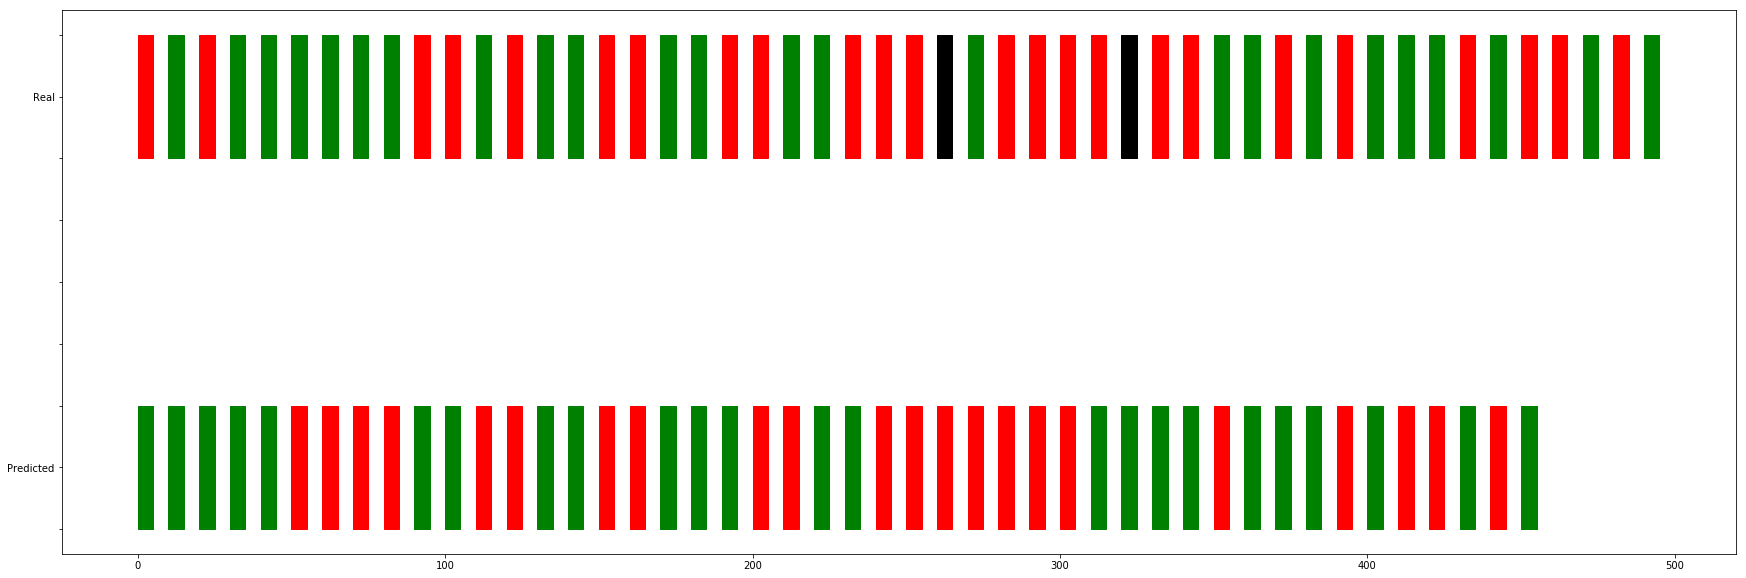

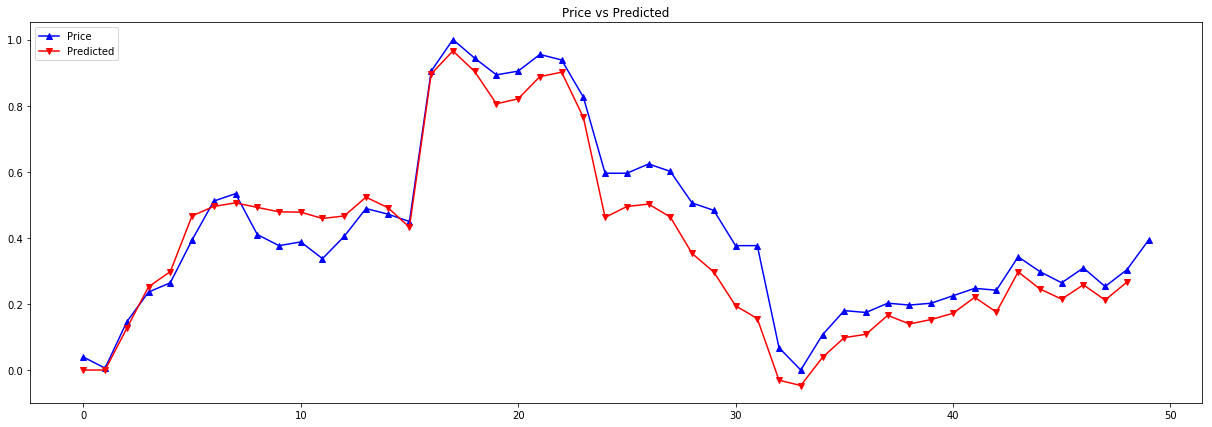

In [652]:
fig, ax = plt.subplots(1,1)

# Instead of set_figwidth(30)
fig.set_size_inches(30, 10, forward=True)
# quotes = np.genfromtxt("./out.csv", skip_header=1, delimiter=',')
p1 = draw_rects(ax, datasetTest.color_original.count(),colordraw=datasetTest.color_original, yloc=4)
# print(xTrain[:10])
p2 = draw_rects(ax, datasetTest.color_predicted.count(),colordraw=datasetTest.color_predicted, yloc=1)
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[2] = 'Predicted'
labels[8] = 'Real'
ax.set_yticklabels(labels)
plt.figure(figsize=(21,7))
plt.plot(yTest,label='Price',color='blue',marker='^')
plt.plot(test_pred_list,label='Predicted',color='red', marker='v')
plt.title('Price vs Predicted')
plt.legend(loc='upper left')
plt.show()
# PlotmeGraphwithBars(datasetTest,yTest,test_pred_list,"Predicted")

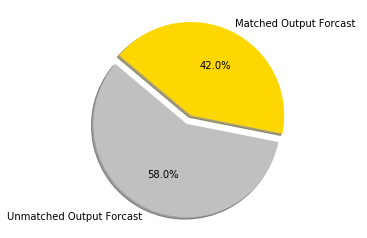

In [653]:
PlotmePercent(datasetTest.open.count()-out.open.count(),out.open.count())

# Checking forecast

In [654]:
xForecast = datasetforecast[['open','high','low','close',"k","d","atr","macdmain","macdsgnal","bbup","bbmid","bblow"]].as_matrix()
yForecast = datasetforecast['closeTarget'].as_matrix()

# Forecast the values using the forcast values

In [655]:
test_pred_list = []
testAndforecast(xForecast,yForecast)
test_pred_list.insert(0,0)
test_pred_list.insert(0,0)

INFO:tensorflow:Restoring parameters from models\model2298.ckpt


In [656]:
datasetforecast.loc[:,'forecast_close'] = pd.Series(test_pred_list[:])
datasetforecast['closeshift'] = datasetforecast.close.shift(-1)
datasetforecast['color_original'] = pd.Series(GetPredictedColor(datasetforecast.closeshift))#dataset_forecast.color.shift(-1)

datasetforecast.loc[:,'color_forecasted'] = pd.Series(GetPredictedColor(test_pred_list))
datasetforecast.color_forecasted = datasetforecast.color_forecasted.fillna('w')
datasetforecast.color_original = datasetforecast.color_original.fillna('w')

49
49


In [657]:
datasetforecast.tail()

,open,high,low,close,k,d,atr,macdmain,macdsgnal,bbup,bbmid,bblow,closeTarget,forecast_close,closeshift,color_original,color_forecasted
45,0.346939,0.259259,0.368421,0.304348,0.0,0.000000,0.051799,0.357759,0.139288,0.051799,0.314782,0.584906,0.0,0.249830,0.217391,r,r
46,0.346939,0.259259,0.342105,0.217391,0.0,0.000000,0.000000,0.280172,0.077093,0.000000,0.321478,0.541779,0.0,0.190260,0.239130,g,r
47,0.265306,0.296296,0.342105,0.239130,0.0,0.055850,0.020555,0.288793,0.078283,0.020555,0.295735,0.493261,0.0,0.149721,0.260870,g,r
48,0.285714,0.222222,0.368421,0.260870,0.0,0.206972,0.096729,0.245690,0.113973,0.096729,0.257131,0.447439,0.0,0.222719,0.195652,r,g
49,0.306122,0.222222,0.315789,0.195652,0.0,0.234568,0.183060,0.202586,0.099318,0.183060,0.252112,0.407008,0.0,NaN,NaN,w,w


# Plot the graph between Shifted closed values of the test and the Forecasted close values.

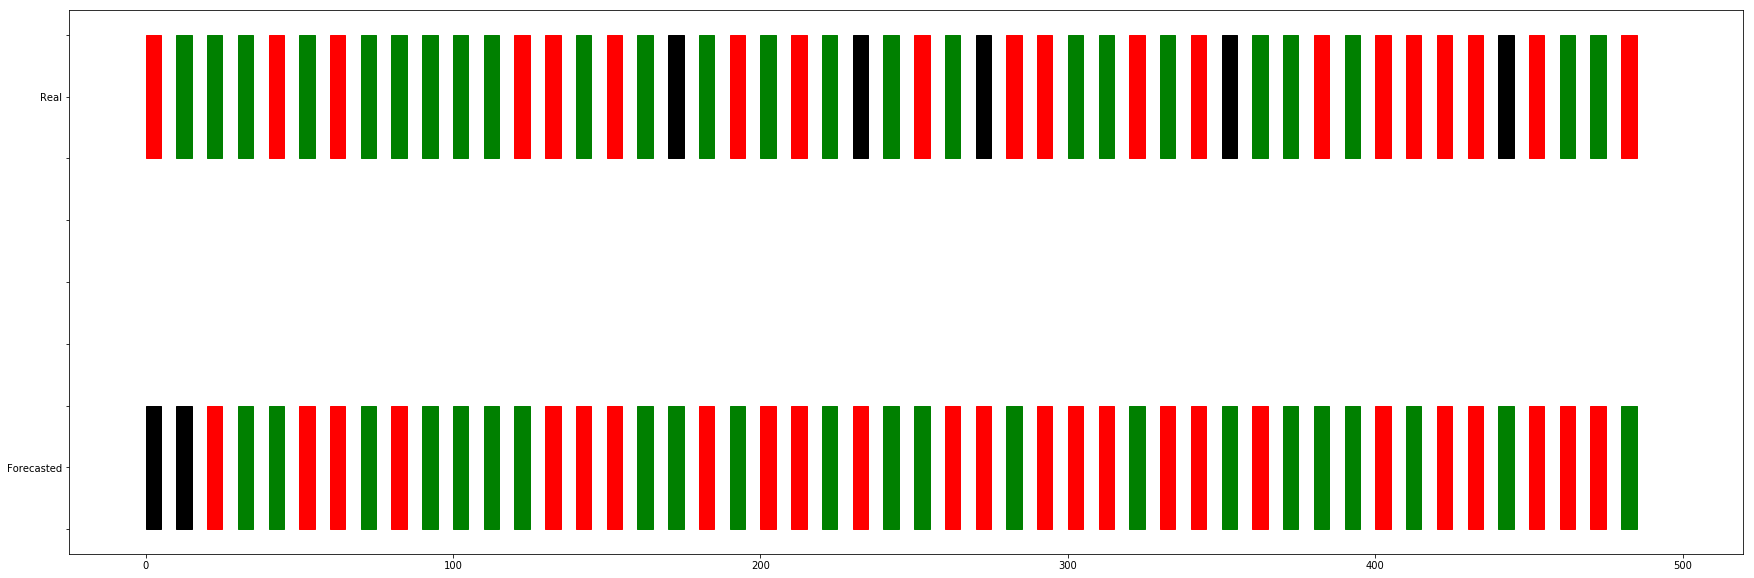

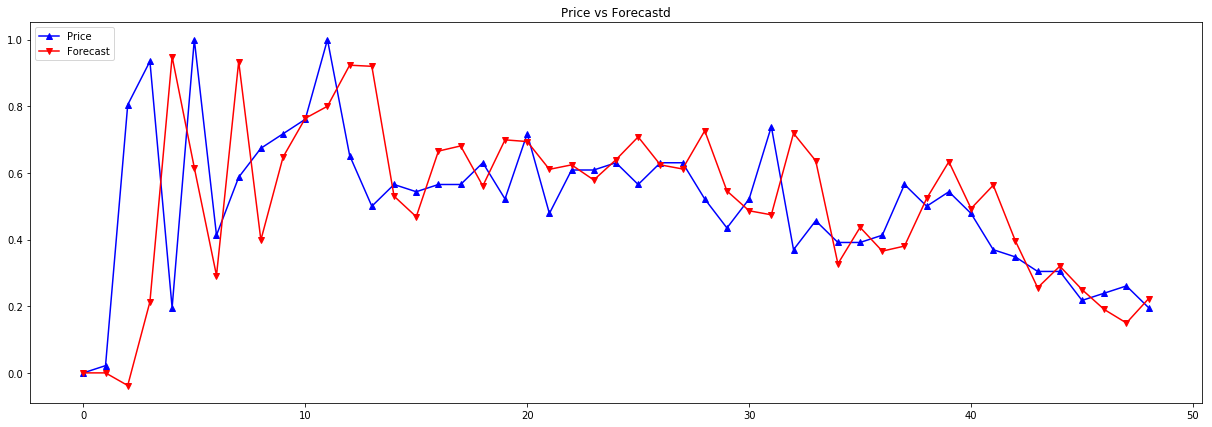

In [658]:
fig, ax = plt.subplots(1,1)

# Instead of set_figwidth(30)
fig.set_size_inches(30, 10, forward=True)
# quotes = np.genfromtxt("./out.csv", skip_header=1, delimiter=',')
p1 = draw_rects(ax, datasetforecast.color_original.count(),colordraw=datasetforecast.color_original, yloc=4)
# print(xTrain[:10])
p2 = draw_rects(ax, datasetforecast.color_forecasted.count(),colordraw=datasetforecast.color_forecasted, yloc=1)
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[2] = 'Forecasted'
labels[8] = 'Real'
ax.set_yticklabels(labels)
plt.figure(figsize=(21,7))
plt.plot(datasetforecast.close.shift(-1),label='Price',color='blue',marker='^')
plt.plot(test_pred_list,label='Forecast',color='red',marker='v')
plt.title('Price vs Forecastd')
plt.legend(loc='upper left')
plt.show()

In [659]:
display(datasetforecast.head())

,open,high,low,close,k,d,atr,macdmain,macdsgnal,bbup,bbmid,bblow,closeTarget,forecast_close,closeshift,color_original,color_forecasted
0,0.346939,0.277778,0.342105,0.239130,0.0,0.097737,0.095923,0.008621,0.289514,0.095923,0.000000,0.045822,0.0,0.000000,0.000000,r,k
1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.071942,0.004310,0.079558,0.071942,0.011642,0.008086,0.0,0.000000,0.021739,g,k
2,0.061224,0.018519,0.078947,0.021739,0.0,0.034495,0.048667,0.000000,0.000000,0.048667,0.020441,0.000000,0.0,-0.037858,0.804348,g,r
3,0.081633,0.740741,0.105263,0.804348,0.0,0.665193,0.257515,0.163793,0.582643,0.257515,0.199662,0.102426,0.0,0.213083,0.934783,g,g
4,0.795918,1.000000,0.289474,0.934783,0.0,1.000000,0.625557,0.288793,0.988672,0.625557,0.412328,0.210243,0.0,0.948781,0.195652,r,g


# Plot the Box graph between Shifted closed values of the test and the predicted close values.

In [619]:
datasetforecast.to_csv('forecasted.csv')

In [620]:
datasetforecast.open.count()

50

In [621]:
out=datasetforecast[(datasetforecast.color_original == datasetforecast.color_forecasted)]
out.open.count()

35

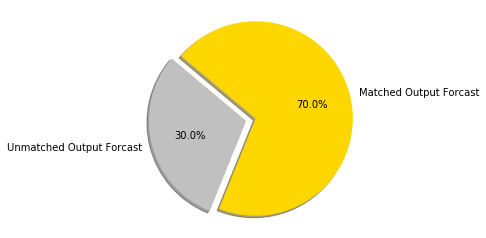

In [622]:
PlotmePercent(datasetforecast.open.count()-out.open.count(),out.open.count())


In [623]:
# fig, ax = plt.subplots(1,1)

# # Instead of set_figwidth(30)
# fig.set_size_inches(30, 10, forward=True)
# # quotes = np.genfromtxt("./out.csv", skip_header=1, delimiter=',')
# p1 = draw_rects(ax, datasetforecast,colordraw=datasetforecast.color_original, yloc=4)
# # print(xTrain[:10])
# p2 = draw_rects(ax, datasetforecast,colordraw=datasetforecast.color_predicted, yloc=1)
# labels = [item.get_text() for item in ax.get_yticklabels()]
# labels[2] = 'Forecast'
# labels[8] = 'Real'
# ax.set_yticklabels(labels)

# plt.show()

In [624]:
# range(len(test_pred_list))

In [625]:
# colorcandle

In [626]:
# list(yTest)

In [627]:
# list(test_pred_list)

In [628]:
# trace = go.Candlestick(open=datasetTest.open[1:100],
#                        high=datasetTest.high[1:100],
#                        low=datasetTest.low[1:100],
#                        close=list(yTest[1:100]))
# layout = {'title':"Tested Output"}
# data = [trace]
# fig = dict(data=data, layout=layout)
# py.iplot(fig, filename='simple_TestPredict')
# trace = go.Candlestick(open=datasetTest.open[1:100],
#                        high=datasetTest.high[1:100],
#                        low=datasetTest.low[1:100],
#                        close=test_pred_list[1:100])
# layout = {'title':"Predicted Output"}
# data = [trace]
# fig = dict(data=data, layout=layout)
# py.iplot(fig, filename='simple_TestPredict')